# DDPG (Deep Deterministic Policy Gradient)

In [1]:
!apt install python-opengl
!apt install ffmpeg
!apt install xvfb
!pip install -q pyvirtualdisplay
from pyvirtualdisplay import Display

# Start virtual display
dis = Display(visible=0, size=(600, 400))
dis.start()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
The following packages were automatically installed and are no longer required

# 03. DDPG

[T. P. Lillicrap et al., "Continuous control with deep reinforcement learning." arXiv preprint arXiv:1509.02971, 2015.](https://arxiv.org/pdf/1509.02971.pdf)

<img src="https://enfow.github.io/image/paper-review/ddpg_algorithm.png" width=600 />
<img src="https://miro.medium.com/max/1200/1*-87grz5iUZK4i7NCH1ldbw.png" width=300 />

Deep Q Network(DQN)([Mnih et al., 2013;2015](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf)) 알고리즘은 강화 학습과 Deep Learning의 발전을 결합합니다. 그러나 DQN은 고차원 observation 공간의 문제를 해결하지만 greedy 정책을 사용하기 때문에 이산 및 저차원 action space만 처리할 수 있습니다. 고차원적이고 연속적인 action space에서 학습하기 위해 저자는 actor critic 접근 방식과 최근 DQN 성공의 통찰력을 결합합니다. Deep DPG(DDPG)는 DPG(Deterministic Policy Gradient) 알고리즘을 기반으로 합니다(Silver et al., 2014).

### Deterministic policy gradient
DPG 알고리즘은 state를 특정 action에 deterministic하게 매핑하여 현재 정책을 지정하는 매개변수화된 actor 함수 $\mu(s|\theta^{\mu})$를 유지 관리합니다. critic $Q(s, a)$는 Q-learning에서와 같이 Bellman 방정식을 사용하여 학습됩니다. actor는 액터 매개변수와 관련하여 시작 분포 $J$의 기대 이득(expected return)에 chain rule을 적용하여 업데이트됩니다.

$$
\begin{align*}
\nabla_{\theta^{\mu}}J &\approx E_{s_t\sim\rho^\beta} [\nabla_{\theta^{\mu}} Q(s,a|\theta^Q)|_{s=s_t, a=\mu(s_t|\theta^\mu)}] \\|
&= E_{s_t\sim\rho^\beta} [\nabla_{a} Q(s,a|\theta^Q)|_{s=s_t, a=\mu(s_t)} \nabla_{\theta^{\mu}} \mu(s|\theta^\mu)|_{s=s_t}]
\end{align*}
$$

### Replay buffer
강화 학습에 신경망을 사용할 때의 한 가지 문제는 대부분의 최적화 알고리즘이 샘플이 독립적이고 동일하게 분포(iid)되어 있다고 가정한다는 것입니다. 샘플이 환경에서 순차적으로 탐색하여 생성되면 이 가정은 더 이상 유효하지 않습니다.  **재생 버퍼**를 사용하여 이러한 문제를 해결합니다. 각 시간 단계에서 actor와 crictor는 버퍼에서 균일하게 미니배치를 샘플링하여 업데이트됩니다. 일련의 **uncorrelated** transition에서 학습의 이점을 얻을 수 있습니다.

### Soft update target network
업데이트되는 네트워크 $(Q(s,a|\theta^Q)$는 타겟 값 계산에도 사용되기 때문에 Q 업데이트는 발산하기 쉽습니다. 이를 피하기 위해  **target network**를 사용합니다. DQN과 비슷하지만 actor-critic 용으로 수정되고 ***soft target update**를 사용합니다. 타겟 네트워크는 대상 값을 계산하는 데 사용되는 actor 및 critic 네트워크, $Q'(s,a|\theta^{Q'})$ and $\mu'(s|\theta^{\mu`})$를 복사하여 생성됩니다.   그런 다음 이러한 대상 네트워크의 가중치는 학습된 네트워크를 천천히 추적하도록 하여 업데이트됩니다.

$$
\theta' \leftarrow \tau \theta + (1 - \tau)\theta' \ \ \ {with} \ \tau \ll 1.
$$

학습의 안정성을 크게 향상시킵니다.

### Exploration for continuous action space
DDPG와 같은 off-policy 알고리즘의 장점은 학습 알고리즘과 독립적으로 탐색 문제를 처리할 수 있다는 것입니다.  noise process $\mathcal{N}$에서 샘플링된 noise를 액터 정책에 추가하여 탐색 정책(exploration policy) $\mu'$을 구성합니다.

$$
\mu'(s_t) = \mu(s_t|\theta^{\mu}_t) + \mathcal{N}
$$

$\mathcal{N}$는 환경에 맞게 선택할 수 있습니다.  **Ornstein-Uhlenbeck 프로세스**를 사용하여 시간적으로 상관된 탐색을 생성합니다.

## Import modules

In [2]:
import copy
import random
from typing import Dict, List, Tuple

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from IPython.display import clear_output

seed = 777
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## 환경
*ActionNormalizer*는 (-1.1) 범위의 액션 값을 정규화하는 액션 래퍼 클래스입니다. 이 클래스 덕분에 에이전트가 0 중심 범위(-1, 1) 내에서 단순히 액션 값을 선택하도록 할 수 있습니다.

In [3]:
class ActionNormalizer(gym.ActionWrapper):
    """Rescale and relocate the actions."""

    def action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (-1, 1) to (low, high)."""
        low = self.action_space.low
        high = self.action_space.high

        scale_factor = (high - low) / 2
        reloc_factor = high - scale_factor

        action = action * scale_factor + reloc_factor
        action = np.clip(action, low, high)

        return action

    def reverse_action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (low, high) to (-1, 1)."""
        low = self.action_space.low
        high = self.action_space.high

        scale_factor = (high - low) / 2
        reloc_factor = high - scale_factor

        action = (action - reloc_factor) / scale_factor
        action = np.clip(action, -1.0, 1.0)

        return action

You can see [the code](https://github.com/openai/gym/blob/master/gym/envs/classic_control/pendulum.py) and [configurations](https://github.com/openai/gym/blob/cedecb35e3428985fd4efad738befeb75b9077f1/gym/envs/__init__.py#L81) of Pendulum-v0 from OpenAI's repository.

In [4]:
# environment
env_id = "Pendulum-v0"
env = gym.make(env_id)
env = ActionNormalizer(env)
env.seed(seed)

obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
print("observation dimension =", obs_dim)
print("action dimension =", action_dim)

observation dimension = 3
action dimension = 1



| Num | Action | Min  | Max |
|-----|--------|------|-----|
| 0   | Torque | -2.0 | 2.0 |

| Num | Observation      | Min  | Max |
|-----|------------------|------|-----|
| 0   | x = cos(theta)   | -1.0 | 1.0 |
| 1   | y = sin(angle)   | -1.0 | 1.0 |
| 2   | Angular Velocity | -8.0 | 8.0 |

r = -(theta<sup>2</sup> + 0.1 * theta_dt<sup>2</sup> + 0.001 * torque<sup>2</sup>)

최소 reward : -(pi<sup>2</sup> + 0.1 * 8<sup>2</sup> + 0.001 * 2<sup>2</sup>) = -16.2736044  
최대 reward : 0 (수직 위치)

### Replay Buffer

In [5]:
import collections

Experience = collections.namedtuple('Experience', 
                                    field_names=['state', 'action', 'reward', 'done', 'next_state'])

class ExperienceReplay:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, dones, next_states = zip(*[self.buffer[idx] for idx in indices])
        return np.array(states, dtype=np.float32), np.array(actions, dtype=np.float32), \
                  np.array(rewards, dtype=np.float32), \
                  np.array(dones, dtype=np.float32), np.array(next_states, dtype=np.float32)

## OU Noise
- Exploitation/Exlporation Dilemma 해결책으로 neural network 에서 출력한 action 에 약간의 noise 를 추가  
- DDPG 가 off-policy 알고리즘이므로 noise 를 추가하는 policy 에서 선택된 action 으로 생성된 sample 도 사용 가능  
**Ornstein-Uhlenbeck (확률미분방정식)** 프로세스는 시간 상관 탐색을 생성하고 관성의 물리적 제어 문제에 효과적으로 대처합니다.

$$
dx_t = \theta(\mu - x_t) dt + \sigma dW_t
$$

In [6]:
class OUNoise:
    """Ornstein-Uhlenbeck process.
    Taken from Udacity deep-reinforcement-learning github repository:
    https://github.com/udacity/deep-reinforcement-learning/blob/master/
    ddpg-pendulum/ddpg_agent.py
    """
    def __init__(
        self, 
        size: int, 
        theta: float = 0.15, 
        sigma: float = 0.2,
    ):
        """Initialize parameters and noise process."""
        self.state = np.float64(0.0)
        self.mu = np.zeros(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self) -> np.ndarray:
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array(
            [random.random() for _ in range(len(x))]
        )
        self.state = x + dx
        return self.state

In [7]:
#  noise (OUNoise): noise generator for exploration
ou_noise_theta = 1.0
ou_noise_sigma = 0.1

ou_noise = OUNoise(
    action_dim,
    theta=ou_noise_theta,
    sigma=ou_noise_sigma,
)
ou_noise.sample()

array([0.02293341])

## Network
Actor와 critic에 대해 두 개의 별도 네트워크를 사용할 것입니다. Actor network의 출력층에는 **tanh**가 사용됩니다. 반면 Critic 네트워크의 출력층은 linear 입니다. 또한 Critic 네트워크의 입력 크기는 state 크기와 action 크기의 합입니다. 

In [8]:
class Actor(nn.Module):
    def __init__(
        self, 
        in_dim: int, 
        out_dim: int,
        init_w: float = 3e-3,
    ):
        """Initialize."""
        super(Actor, self).__init__()
        
        self.hidden1 = nn.Linear(in_dim, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, out_dim)

        self.out.weight.data.uniform_(-init_w, init_w)
        self.out.bias.data.uniform_(-init_w, init_w)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = F.relu(self.hidden1(state))
        x = F.relu(self.hidden2(x))
        action = self.out(x).tanh() 
        
        return action
    
class Critic(nn.Module):
    def __init__(
        self, 
        in_dim: int, 
        init_w: float = 3e-3,
    ):
        """Initialize."""
        super(Critic, self).__init__()
        
        self.hidden1 = nn.Linear(in_dim, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, 1)

        self.out.weight.data.uniform_(-init_w, init_w)
        self.out.bias.data.uniform_(-init_w, init_w)

    def forward(
        self, state: torch.Tensor, action: torch.Tensor
    ) -> torch.Tensor:
        """Forward method implementation."""
        x = torch.cat((state, action), dim=-1)   #Q(s, a)를 critic으로 사용하므로 state+action 을 입력으로 사용
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        value = self.out(x)
        
        return value

In [9]:
# actor networks
actor = Actor(obs_dim, action_dim).to(device)
actor_target = Actor(obs_dim, action_dim).to(device)
actor_target.load_state_dict(actor.state_dict())

# critic network의 input size 는 obs_dim + action_dim
critic = Critic(obs_dim + action_dim).to(device)
critic_target = Critic(obs_dim + action_dim).to(device)
critic_target.load_state_dict(critic.state_dict())

# optimizer
actor_optimizer = optim.Adam(actor.parameters(), lr=3e-4)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)

## DDPG Agent
다음은 DDPGAgent 클래스에 대한 요약입니다.

| Method           | Note                                                 |
|---               |---                                                  |
|select_action     | select an action from the input state.               |
|update_model      | update the model by gradient descent.                |
|train             | train the agent during num_frames.                   |
|\_target_soft_update| soft update from the local model to the target model.|
|\_plot              | plot the training progresses.                        |

In [10]:
class DDPGAgent:
    """DDPGAgent interacting with environment.
        memory (ReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        gamma (float): discount factor
        tau (float): parameter for soft target update
        initial_random_steps (int): initial random action steps
        total_step (int): total step numbers
    """
    def __init__(
        self,
        memory_size: int,
        batch_size: int,
        gamma: float = 0.99,
        tau: float = 5e-3,
        initial_random_steps: int = 1e4,
    ):
        """Initialize."""
        self.memory = ExperienceReplay(memory_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.initial_random_steps = initial_random_steps
        
        # total steps count
        self.total_step = 0
    
    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        # 초기 무작위 action을 수행해야 하는 경우
        if self.total_step < self.initial_random_steps:
            selected_action = env.action_space.sample()
        else:
            selected_action = actor(
                torch.FloatTensor(state).to(device)
            ).detach().cpu().numpy()
        
        # 훈련 중 탐색을 위해 노이즈 추가
        noise = ou_noise.sample()
        selected_action = np.clip(selected_action + noise, -1.0, 1.0)
        
        return selected_action
    
    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""
        states, actions, rewards, dones, next_states = self.memory.sample(self.batch_size)
        state = torch.FloatTensor(states).to(device)
        action = torch.FloatTensor(actions.reshape(-1, 1)).to(device)
        reward = torch.FloatTensor(rewards.reshape(-1, 1)).to(device)
        done = torch.FloatTensor(dones.reshape(-1, 1)).to(device)
        next_state = torch.FloatTensor(next_states).to(device)

        masks = 1 - done
        next_action = actor_target(next_state)
        next_value = critic_target(next_state, next_action)
        curr_return = reward + self.gamma * next_value * masks
        
        # train critic
        values = critic(state, action)
        critic_loss = F.mse_loss(values, curr_return)
        
        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()
                
        # train actor
        actor_loss = -critic(state, actor(state)).mean()
        
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()
        
        # target update
        self._target_soft_update()
        
        return actor_loss.detach().cpu().numpy(), critic_loss.detach().cpu().numpy()
    
    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""    
        state = env.reset()
        actor_losses = []
        critic_losses = []
        scores = []
        score = 0
        
        for self.total_step in range(1, num_frames + 1):
            action = self.select_action(state)

            next_state, reward, done, _ = env.step(action)

            experience = Experience(state, action, reward, done, next_state)
            self.memory.add(experience)

            state = next_state
            score += reward

            # if episode ends
            if done:         
                state = env.reset()
                scores.append(score)
                score = 0

            # if training is ready
            if (
                len(self.memory) >= self.batch_size 
                and self.total_step > self.initial_random_steps
            ):
                actor_loss, critic_loss = self.update_model()
                actor_losses.append(actor_loss)
                critic_losses.append(critic_loss)
            
            # plotting
            if self.total_step % plotting_interval == 0:
                self._plot(
                    self.total_step, 
                    scores, 
                    actor_losses, 
                    critic_losses,
                )    
        env.close()
    
    def _target_soft_update(self):
        """Soft-update: target = tau*local + (1-tau)*target."""
        tau = self.tau
        
        for t_param, l_param in zip(actor_target.parameters(), actor.parameters()):
            t_param.data.copy_(tau * l_param.data + (1.0 - tau) * t_param.data)
        
        for t_param, l_param in zip(critic_target.parameters(), critic.parameters()):
            t_param.data.copy_(tau * l_param.data + (1.0 - tau) * t_param.data)
    
    def _plot(
        self, 
        frame_idx: int, 
        scores: List[float], 
        actor_losses: List[float], 
        critic_losses: List[float], 
    ):
        """Plot the training progresses."""
        def subplot(loc: int, title: str, ylabel: str, values: List[float]):
            plt.subplot(loc)
            plt.title(title)
            plt.ylabel(ylabel)
            plt.plot(values)

        subplot_params = [
            (131, f"frame {frame_idx}. score: {np.mean(scores[-10:])}", "last 10 rewards",scores),
            (132, "actor_loss", "loss", actor_losses),
            (133, "critic_loss", "loss", critic_losses),
        ]
        
        clear_output(True)
        plt.figure(figsize=(30, 5))
        for loc, title, ylabel, values in subplot_params:
            subplot(loc, title, ylabel, values)

        plt.show()

## Initialize

In [11]:
# parameters
num_frames = 50_000
memory_size = 100_000
batch_size = 32
initial_random_steps = 10_000

agent = DDPGAgent(
    memory_size, 
    batch_size,
    initial_random_steps=initial_random_steps
)

## Train

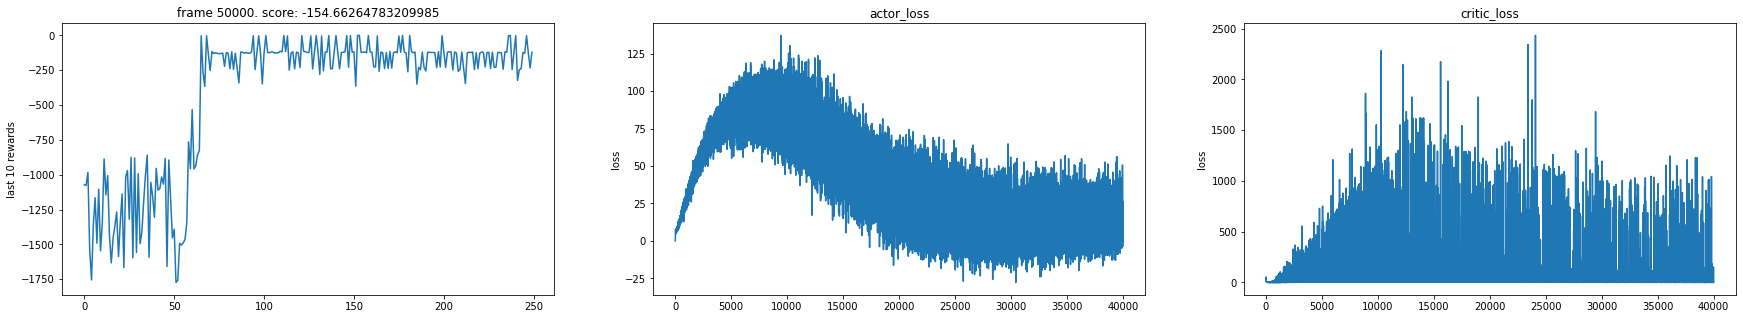

In [12]:
agent.train(num_frames)

## Test
훈련된 에이전트를 실행합니다(1개 에피소드).

In [13]:
env = gym.wrappers.Monitor(env, "videos", force=True)

state = env.reset()
done = False
while not done:
    _ = env.render(mode="rgb_array")
    action = actor(
                torch.FloatTensor(state).to(device)
            ).detach().cpu().numpy()

    next_state, reward, done, _ = env.step(action)
    state = next_state

env.close()

## Render

In [14]:
import base64
import glob
import io
import os

from IPython.display import HTML, display

def ipython_show_video(path: str) -> None:
    """Show a video at `path` within IPython Notebook."""
    if not os.path.isfile(path):
        raise NameError("Cannot access: {}".format(path))

    video = io.open(path, "r+b").read()
    encoded = base64.b64encode(video)

    display(HTML(
        data="""
        <video alt="test" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4"/>
        </video>
        """.format(encoded.decode("ascii"))
    ))

list_of_files = glob.glob("videos/*.mp4")
latest_file = max(list_of_files, key=os.path.getctime)
print(latest_file)
ipython_show_video(latest_file)

videos/openaigym.video.0.494.video000000.mp4
